# <center> Gender Biais detection</center>
## <center> Infer the gramatical gender thanks to Word vectors in French  </center>
### <center> Quillivic Robin, 01/03/2019 </center>
In this notebook, we shows that is possible thanks to a tuned ramdom forest, to infer gramatical gender in French.

In [146]:
from gensim import *

from gensim.models import Word2Vec
import logging
import gensim
import os

import itertools

from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors

import matplotlib.pyplot as plt
from random import *

import pandas as pd
import numpy as np
import math

from sklearn.decomposition import PCA
import lib
import fasttext
from gensim.models.wrappers import FastText
import random

# Load the models

In [147]:
# Logging code taken from http://rare-technologies.com/word2vec-tutorial/
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Load pre-trained Word2Vec model.
model_cc  = gensim.models.KeyedVectors.load_word2vec_format(r'DATA\FR\cc.fr.300.vec', binary=False,limit=50000)
model_fr_wac  = gensim.models.KeyedVectors.load_word2vec_format(r'DATA\FR\frWac_no_postag_no_phrase_500_skip_cut100.bin', binary=True,limit=50000)
model_wiki  = gensim.models.KeyedVectors.load_word2vec_format(r'DATA\FR\wiki_fr.vec',binary=False,limit=50000)
model_wiki_lem  = gensim.models.KeyedVectors.load_word2vec_format('C:/Users/Robin/Documents/IMPACT/Notebooks/DATA/FR/ppmi_svd_fr/matrix.txt',binary=False,encoding='latin1')

2019-03-01 16:57:05,530 : INFO : loading projection weights from DATA\FR\cc.fr.300.vec
2019-03-01 16:57:21,296 : INFO : loaded (50000, 300) matrix from DATA\FR\cc.fr.300.vec
2019-03-01 16:57:21,298 : INFO : loading projection weights from DATA\FR\frWac_no_postag_no_phrase_500_skip_cut100.bin
2019-03-01 16:57:22,199 : INFO : loaded (50000, 500) matrix from DATA\FR\frWac_no_postag_no_phrase_500_skip_cut100.bin
2019-03-01 16:57:22,200 : INFO : loading projection weights from DATA\FR\wiki_fr.vec
2019-03-01 16:57:38,298 : INFO : loaded (50000, 300) matrix from DATA\FR\wiki_fr.vec
2019-03-01 16:57:38,301 : INFO : loading projection weights from C:/Users/Robin/Documents/IMPACT/Notebooks/DATA/FR/ppmi_svd_fr/matrix.txt
2019-03-01 16:58:20,920 : INFO : loaded (53376, 500) matrix from C:/Users/Robin/Documents/IMPACT/Notebooks/DATA/FR/ppmi_svd_fr/matrix.txt


# Load the Lexique 
from http://www.lexique.org/telLexique.php

In [148]:
#Load lexique in a Dataframe
df = pd.read_excel(r'DATA\FR\Lexique382.xlsx',encoding='latin1')

In [156]:
def merge_model_lexique(lexique,model):

    #Isolate the gender and create
    df_genre =  lexique[['1_ortho','5_genre']]
    df_genre = pd.DataFrame(data = df_genre.values,columns=['Mot','genre'])
    #Load the word of the model
    df_model = pd.DataFrame(list(model.vocab.items()), columns=['Mot','count'])
    # Merge the vocab of the Lexique and the model
    result = pd.merge(df_model,df_genre, on='Mot')
    #keep only the word where there is a gender
    result = result.dropna()
    
    return(result)

def genre(x):
    """
    transform the gender f,m into 0,1
    """
    if 'f' in str(x):
        return(0)
    if 'm' in str(x) :
        return(1)

def built_X_y(result,model):
    X=[]
    for word in list(result['Mot']):
        X.append(model[word])
        
    y = result['genre'].apply(genre)
    return(np.asarray(X),y)
    

In [157]:
X_cc,y_cc = built_X_y(merge_model_lexique(df,model_cc),model_cc) 
X_frwac,y_frwac = built_X_y(merge_model_lexique(df,model_fr_wac),model_fr_wac) 
X_wiki,y_wiki = built_X_y(merge_model_lexique(df,model_wiki),model_wiki)
X_wiki_lem,y_wiki_lem = built_X_y(merge_model_lexique(df,model_wiki_lem),model_wiki_lem) 

C:\Users\Robin\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


# Train and evaluate a classifier

In [184]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import roc_auc_score,accuracy_score
import time

def trainTuneTest(X,y) :
    print('In this data set, there are ',len(X),'words.')
    print('We will use 66% for training a random forest and then  compute ROC-AUC score on the 33% remaning ')
    #Split in train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4)
    # choice ofthe classifier : here rancdom forest
    clf = RandomForestClassifier()
    # set of parameters thta needs to be tuned
    param_grid = {"max_depth": [3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],"n_estimators": [100]}
    #fit the grid search
    grid_search = GridSearchCV(clf, param_grid=param_grid, cv=3,scoring = 'roc_auc',return_train_score=False)
    start = time.time()
    grid_search.fit(X_train, y_train)
    # store the result of the grid search in a dataFrame
    df_result = pd.DataFrame(grid_search.cv_results_)
    final = time.time()
    print('The grid search take: ',abs(start-final),'s  to fit')
    #fit the classifier witht tht best paramaters
    #predict
    y_pred = grid_search.predict(X_test)
    roc = roc_auc_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    print(' the ROC- AUC score is', roc)
    print(' the accuracy score is', acc)
    return(roc,acc, df_result)
    
    



In [185]:
ROC =[]
ACC = []
R=[]
i=0
MODEL = [model_cc ,model_fr_wac, model_wiki ,model_wiki_lem]
model_label = ['Commom crawl FastTest', 'Common Crawl W2V', 'Wiki_fr','Wiki_fr lem']
for model in MODEL:
    print('###########################')
    print(model_label[i])
    print('###########################')
    X,y = built_X_y(merge_model_lexique(df,model),model)
    # compute and train the model
    roc,acc, df_result = trainTuneTest(X,y)
    # complete the tab
    ROC.append(roc)
    ACC.append(acc)
    R.append(df_result)
    i+=1
    print('-------------------------------------------------------------------')
    
    

###########################
Commom crawl FastTest
###########################


C:\Users\Robin\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In this data set, there are  23329 words.
We will use 66% for training a random forest and then  compute ROC-AUC score on the 33% remaning 
The grid search take:  278.71503615379333 s  to fit
 the ROC- AUC score is 0.9811456337022355
 the accuracy score is 0.9820755942330173
-------------------------------------------------------------------
###########################
Common Crawl W2V
###########################


C:\Users\Robin\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In this data set, there are  22070 words.
We will use 66% for training a random forest and then  compute ROC-AUC score on the 33% remaning 
The grid search take:  488.99807357788086 s  to fit
 the ROC- AUC score is 0.5433829691121208
 the accuracy score is 0.6703734211971444
-------------------------------------------------------------------
###########################
Wiki_fr
###########################


C:\Users\Robin\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In this data set, there are  26976 words.
We will use 66% for training a random forest and then  compute ROC-AUC score on the 33% remaning 
The grid search take:  426.3131172657013 s  to fit
 the ROC- AUC score is 0.8641873342389548
 the accuracy score is 0.8822868695945187
-------------------------------------------------------------------
###########################
Wiki_fr lem
###########################


C:\Users\Robin\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In this data set, there are  29017 words.
We will use 66% for training a random forest and then  compute ROC-AUC score on the 33% remaning 
The grid search take:  619.2222201824188 s  to fit
 the ROC- AUC score is 0.5852909167576481
 the accuracy score is 0.7251461988304093
-------------------------------------------------------------------


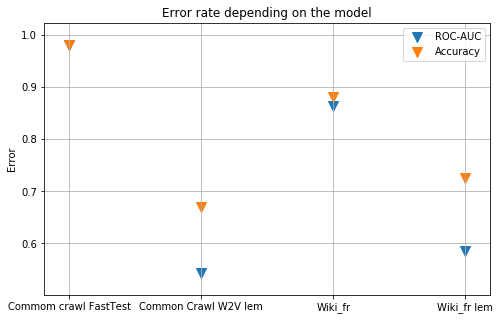

In [190]:
import matplotlib.pyplot as plt
import numpy as np
# Plot the result
model_label = ['Commom crawl FastTest', 'Common Crawl W2V lem', 'Wiki_fr','Wiki_fr lem']
plt.rcParams['figure.facecolor'] = '1'
plt.figure(figsize=(8,5))
plt.scatter(model_label,ROC,
            s=100, marker ="v",label='ROC-AUC')
plt.scatter(model_label,ACC,
            s=100, marker ="v",label='Accuracy')
plt.ylabel("Error")
plt.title('Error rate depending on the model')
plt.legend(loc="best")
plt.grid()
plt.show()

## WEFAT test

In [118]:
A = ['elle','fille','mère']
B = ['il','garçon','père']


In [122]:
def wefat_score(A,B,model):
    WEFAT =[]
    for word in  list(model.vocab):
        WEFAT.append(lib.s(word,A,B,model))
    m = abs(np.asarray(WEFAT)).mean()
    return(m)

In [123]:
print( 'Lem:', wefat_score(A,B,model_lem))
print( 'no_lem:', wefat_score(A,B,model))

Lem: 0.5002405961046998
no_lem: 0.7748642286580472


In [141]:
X = ['informaticien', 'ingénieur', 'scientifique','docteur'] 
Y = ['professeur', 'libraire','secrétaire','ménager']
X=['mathématique', 'algèbre', 'géométrie', 'calcul', 'équation']# 'computation', 'numbers', 'addition']
Y =['poésie', 'art', 'danse', 'littérature', 'roman']# 'symphony', 'drama', 'sculpture']  

In [142]:
print( 'Lem:',lib.S(X,Y,A,B,model_lem)*100)
print( 'no_lem:', lib.S(X,Y,A,B,model)*100)

Lem: -2.9076754425962776
no_lem: -13.98049145936966


In [143]:
e= lib.effet_size(X,Y,A,B,model_lem)
print(' the effect size is with lem',e)
e= lib.effet_size(X,Y,A,B,model)
print(' the effect size is with no lem',e)

 the effect size is with lem 0.7646246370043525
 the effect size is with no lem 0.04636333583186686


In [144]:
p = lib.p_values(X,Y,A,B,model_lem)
print(' the p values is',p,'with the lem')

166015
 the p values is 0.81956004462743 with the lem


In [145]:
p = lib.p_values(X,Y,A,B,model)
print(' the p values is',p,'with no lem')

199582
 the p values is 0.9852689987460876 with no lem
